In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import cv2
import numpy as np
import pickle as pickle
import glob
%matplotlib inline

In [2]:
ls

Camera Calibration.ipynb    example_writeup.pdf
Experimenting.ipynb         examples/
README.md                   harder_challenge_video.mp4
camera_cal/                 output_images/
camera_calibration.p        project_video.mp4
camera_calibration.pkl      test_images/
challenge_video.mp4         writeup_template.md


In [3]:
data = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = data['mtx']
dist = data['dist']


In [4]:
ls camera_cal/

calibration1.jpg   calibration14.jpg  calibration19.jpg  calibration5.jpg
calibration10.jpg  calibration15.jpg  calibration2.jpg   calibration6.jpg
calibration11.jpg  calibration16.jpg  calibration20.jpg  calibration7.jpg
calibration12.jpg  calibration17.jpg  calibration3.jpg   calibration8.jpg
calibration13.jpg  calibration18.jpg  calibration4.jpg   calibration9.jpg


In [5]:
img = mpimg.imread('camera_cal/calibration1.jpg')

#### Show effect of undistortion

In [6]:
undist = cv2.undistort(img, mtx, dist, None, mtx)

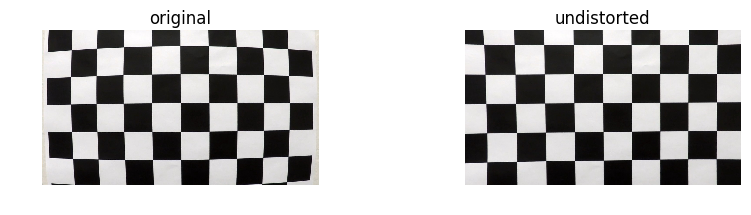

In [7]:
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off');
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title('undistorted')
plt.axis('off');

### Function definitions

Sobel

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

Magnitude of the gradient

In [9]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # sobel x and y
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=sobel_kernel)

    sobel_xy = np.sqrt(sobelx**2 + sobely**2)
    print('sobel_xy: ', sobel_xy)
    print(':: ',np.max(sobel_xy, axis = 0))
    print('sobel_xy: ', sobel_xy.shape)
    sf = np.max(sobel_xy/255)
    gradmag = (sobel_xy/sf).astype(np.uint8)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output

Direction of the gradient

In [10]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_x= np.absolute(sobelx)
    abs_y = np.absolute(sobely)
    
    
    direction = np.arctan2(abs_y, abs_x)
    
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

#### Color gradient

color gradient selection

In [24]:
def color_threshold(img, sthresh=(0, 255), vthresh = (0, 255)):
    """
    This function takes in two thresholds, s in HLS and v in HSV and the image and it 
    returns the combination output binary of both gradients
    """
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    
    # s channel
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > sthresh[0]) & (s <= sthresh[1])] = 1
    
    # v channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # isolate v channel
    v = hsv[:,:,2]
    v_binary = np.zeros_like(v)
    v_binary[(v > vthresh[0]) & (v <= vthresh[1])] = 1

    # create combination of both binaries as output
    output_binary = np.zeros_like(s)
    output_binary[(s_binary == 1) | (v_binary == 1)] = 1

    return output_binary

#### Perspective Transform

#### Color Mask

#### Combine masks

#### Sobel Filters

In [13]:
for idx, fname in enumerate(glob.glob('test_images/*.jpg')):
    # read in the image
    img = cv2.imread(fname)
    # undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # preprocessing
    
    # grab single channel of the image
    preprocessImage = np.zeros_like(img[:,:,0])
    
    # apply sobel gradient x thresholds
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=12, thresh_max=255)
    
    # apply sobel gradient y thresholds
    grady = abs_sobel_thresh(img, orient='y', thresh_min=25, thresh_max=255)
    
    # apply color gradient threshold
    c_binary = color_threshold(img, sthresh = (100, 255), vthresh=(0, 255))

    
    result = img
    # apply all three thresholds to preprocessImage and set true's to 1
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 1
    
    write_name = './test_images/tracked' + str(idx) + '.jpg'
    cv2.imwrite(write_name, result)

    

In [14]:
ls

Camera Calibration.ipynb    example_writeup.pdf
Experimenting.ipynb         examples/
README.md                   harder_challenge_video.mp4
camera_cal/                 output_images/
camera_calibration.p        project_video.mp4
camera_calibration.pkl      test_images/
challenge_video.mp4         writeup_template.md


### Show postprocessed results

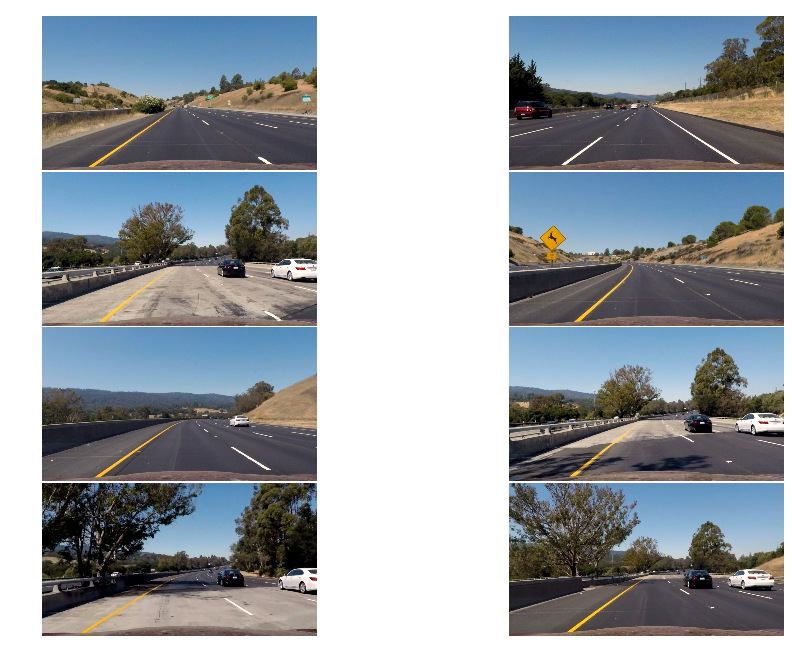

In [23]:
plt.figure(figsize=(12,8))
gs1 = gridspec.GridSpec(4, 2)
gs1.update(wspace = 0.01, hspace = 0.01)
    
for idx, fname in enumerate(glob.glob('test_images/tracked*.jpg')):
#     print('idx: ', idx) 15
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.imshow(img)
plt.show()
